# **Lighthouse Data Challenge**

## **0. Imports and Setup**

In [109]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

## **1. Exploratory Data Analysis**

### **1.1 Overview**

In [110]:
loans = pd.DataFrame()

dirname = os.path.abspath('')
path = os.path.join(dirname, 'data')
all_files = glob.glob(os.path.join(path , "*.gz"))
for filename in all_files:
    df = pd.read_csv(filename, compression='gzip')
    quarterName = os.path.basename(filename).split('.', 1)[0]
    year = quarterName[0:4]
    quarter = quarterName[5:]
    df['year'] = year
    df['quarter'] = quarter
    loans = pd.concat([loans,df])

loans = loans.set_index('id')

In [111]:
print('Number of loans = {}'.format(loans.shape[0]))
print('Shape: {}'.format(loans.shape))
print('Columns: {}'.format(list(loans.columns)))

Number of loans = 438991
Shape: (438991, 56)
Columns: ['funded_amnt', 'term', 'int_rate', 'installment', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'application_type', 'annual_inc_joint', 'dti_joint', 'open_act_il', 'open_il_24m', 'il_util', 'open_rv_24m', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'total_bal_ex_mort', 'total_bc_limit', 'revol_bal_joint', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths

In [112]:
print(loans.info())
loans.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438991 entries, 73688651 to 124836913
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     438991 non-null  int64  
 1   term                            438991 non-null  object 
 2   int_rate                        438991 non-null  object 
 3   installment                     438991 non-null  float64
 4   emp_title                       408624 non-null  object 
 5   emp_length                      408978 non-null  object 
 6   home_ownership                  438991 non-null  object 
 7   annual_inc                      438991 non-null  float64
 8   loan_status                     438991 non-null  object 
 9   purpose                         438991 non-null  object 
 10  zip_code                        438991 non-null  object 
 11  addr_state                      438991 non-null  object 
 12  dti   

,funded_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,loan_status,purpose,...,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,year,quarter
id,,,,,,,,,,,,,,,,,,,,,
122371638,35000,36 months,9.44%,1120.18,Elevator Mechanic,4 years,MORTGAGE,97000.0,Current,debt_consolidation,...,42.9,1,39177,31700,NaN,NaN,NaN,NaN,2017,4
98427224,3500,36 months,11.39%,115.24,Cheese Shoppe Manager,2 years,RENT,22880.0,Current,credit_card,...,33.3,0,31676,9100,NaN,NaN,NaN,NaN,2017,1
116269186,16800,60 months,10.42%,360.44,Case Manager,5 years,OWN,50000.0,Current,debt_consolidation,...,0.0,0,35295,29500,NaN,NaN,NaN,NaN,2017,3
104895146,16000,36 months,8.24%,503.16,Sr. Technical Writer,10+ years,MORTGAGE,106000.0,Current,debt_consolidation,...,50.0,0,191208,15300,NaN,NaN,NaN,NaN,2017,2
93697271,30000,36 months,16.99%,1069.44,"Manager, Systems Analysis",9 years,MORTGAGE,130000.0,Current,debt_consolidation,...,100.0,0,44044,6500,NaN,NaN,NaN,NaN,2016,4


The following features are of object type, but should be represented as numeric types. To do this the numbers are extracted from each string.

In [113]:
loans['term'] = loans['term'].str.extract('(\d+)')
loans['int_rate'] = loans['int_rate'].str.rstrip('%')
loans['revol_util'] = loans['revol_util'].str.rstrip('%')
loans['emp_length'] = loans['emp_length'].str.replace('< 1 year', '0')
loans['emp_length'] = loans['emp_length'].str.replace('10+ years', '10')
loans['emp_length'] = loans['emp_length'].str.extract('(\d+)')
loans['zip_code'] = loans['zip_code'].str.rstrip('xx')
loans.head()

,funded_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,loan_status,purpose,...,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,year,quarter
id,,,,,,,,,,,,,,,,,,,,,
73688651,4000,36,11.99,132.84,Fraud analyst,8,RENT,45000.0,Fully Paid,debt_consolidation,...,0.0,0,1102,7500,NaN,NaN,NaN,NaN,2016,1
75678977,7200,36,11.47,237.33,Client Relations Manager,0,RENT,85000.0,Current,debt_consolidation,...,100.0,0,33021,14000,NaN,NaN,NaN,NaN,2016,1
71905793,20000,36,16.29,706.01,Registerd nurse,8,MORTGAGE,56000.0,Current,debt_consolidation,...,75.0,2,54298,9700,NaN,NaN,NaN,NaN,2016,1
74231221,16000,60,12.99,363.97,Financial Advisor,5,MORTGAGE,110000.0,Current,debt_consolidation,...,87.5,0,45733,39400,NaN,NaN,NaN,NaN,2016,1
68884968,28000,60,15.31,670.69,Pharmacist-in-Charge,3,MORTGAGE,180000.0,Current,debt_consolidation,...,100.0,0,273107,51800,NaN,NaN,NaN,NaN,2016,1


In [114]:
loans['term'] = pd.to_numeric(loans['term'])
loans['int_rate'] = pd.to_numeric(loans['int_rate'])
loans['revol_util'] = pd.to_numeric(loans['revol_util'])
loans['emp_length'] = pd.to_numeric(loans['emp_length'])
loans['zip_code'] = pd.to_numeric(loans['zip_code'])
loans['year'] = pd.to_numeric(loans['year'])
loans['quarter'] = pd.to_numeric(loans['quarter'])
loans.dtypes

funded_amnt                         int64
term                                int64
int_rate                          float64
installment                       float64
emp_title                          object
emp_length                        float64
home_ownership                     object
annual_inc                        float64
loan_status                        object
purpose                            object
zip_code                            int64
addr_state                         object
dti                               float64
delinq_2yrs                         int64
earliest_cr_line                   object
fico_range_high                     int64
inq_last_6mths                    float64
mths_since_last_delinq            float64
open_acc                            int64
revol_bal                           int64
revol_util                        float64
total_acc                           int64
application_type                   object
annual_inc_joint                  

In [115]:
loans['loan_status'].value_counts()

Current               251552
Fully Paid            132055
Charged Off            40902
Late (31-120 days)      8209
In Grace Period         4016
Late (16-30 days)       2257
Name: loan_status, dtype: int64

Since there is no target feature in this dataset, one must be created for classification. The loan_status feature can be used to determine if a loan is "good" or "bad". A desirable loan to invest in is one that is fully payed and not chared off or late. A loan that is charged off is a loan that is not payed off and is considered a bad loan. For the sake of simplicity a current loan is also considered a bad loan.

In [116]:
good = ['Fully Paid']
bad = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)']
inprogress = ['Current', 'In Grace Period']
finishedloans = loans[(loans['loan_status'] != inprogress[0]) & (loans['loan_status'] != inprogress[1])]
loans['loan_finished'] = 1
for status in loans['loan_status'].unique():
    if status in inprogress:
        loans.loc[loans['loan_status'] == status, 'loan_finished'] = 0
    if status in good:
        loans.loc[loans['loan_status'] == status, 'good_loan'] = 1
    if status in bad or status in inprogress:
        loans.loc[loans['loan_status'] == status, 'good_loan'] = 0
loans['loan_finished'].fillna(1, inplace=True)

loans['good_loan'] = loans['good_loan'].astype(np.int64)

print(loans['loan_finished'].value_counts())
loans['good_loan'].value_counts()

0    255568
1    183423
Name: loan_finished, dtype: int64


0    306936
1    132055
Name: good_loan, dtype: int64

In [117]:
loans.describe()

,funded_amnt,term,int_rate,installment,emp_length,annual_inc,zip_code,dti,delinq_2yrs,fico_range_high,...,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_inq_last_6mths,year,quarter,loan_finished,good_loan
count,438991.000000,438991.000000,438991.000000,438991.000000,408978.000000,4.389910e+05,438991.000000,438706.000000,438991.000000,438991.000000,...,438991.000000,4.389910e+05,438991.000000,19670.000000,19671.000000,19671.000000,438991.000000,438991.000000,438991.000000,438991.000000
mean,14790.996000,42.383092,13.144058,443.451421,5.932957,7.978605e+04,507.177582,19.053124,0.343415,701.844279,...,0.139611,5.235281e+04,23299.998446,31507.813523,669.674902,0.675258,2016.505222,2.496074,0.417829,0.300815
std,9323.740928,10.604273,5.062600,277.262393,3.757146,8.194272e+04,309.201018,14.427149,0.930063,32.929589,...,0.384764,5.106754e+04,23030.807798,25024.701622,44.342382,1.033539,0.499973,1.132067,0.493202,0.458613
min,1000.000000,36.000000,5.320000,6.680000,0.000000,0.000000e+00,7.000000,-1.000000,0.000000,664.000000,...,0.000000,0.000000e+00,0.000000,0.000000,544.000000,0.000000,2016.000000,1.000000,0.000000,0.000000
25%,7500.000000,36.000000,9.490000,241.130000,2.000000,4.759490e+04,230.000000,12.130000,0.000000,674.000000,...,0.000000,2.138700e+04,8400.000000,14413.000000,644.000000,0.000000,2016.000000,1.000000,0.000000,0.000000
50%,12000.000000,36.000000,12.620000,370.910000,6.000000,6.626400e+04,468.000000,18.100000,0.000000,694.000000,...,0.000000,3.874100e+04,16400.000000,25186.000000,669.000000,0.000000,2017.000000,3.000000,0.000000,0.000000
75%,20000.000000,60.000000,15.590000,593.490000,10.000000,9.500000e+04,797.000000,24.800000,0.000000,719.000000,...,0.000000,6.611400e+04,30400.000000,41353.750000,694.000000,1.000000,2017.000000,4.000000,1.000000,1.000000
max,40000.000000,60.000000,30.990000,1719.830000,10.000000,1.099920e+07,999.000000,999.000000,42.000000,850.000000,...,8.000000,3.408095e+06,719500.000000,304206.000000,850.000000,6.000000,2017.000000,4.000000,1.000000,1.000000


In [118]:
loans.nunique()

funded_amnt                         1554
term                                   2
int_rate                             169
installment                        44023
emp_title                         120032
emp_length                            11
home_ownership                         5
annual_inc                         28079
loan_status                            6
purpose                               14
zip_code                             908
addr_state                            50
dti                                 6986
delinq_2yrs                           29
earliest_cr_line                     680
fico_range_high                       38
inq_last_6mths                         6
mths_since_last_delinq               147
open_acc                              74
revol_bal                          61561
revol_util                          1163
total_acc                            126
application_type                       2
annual_inc_joint                    5103
dti_joint       

### **1.2 Visual EDA**

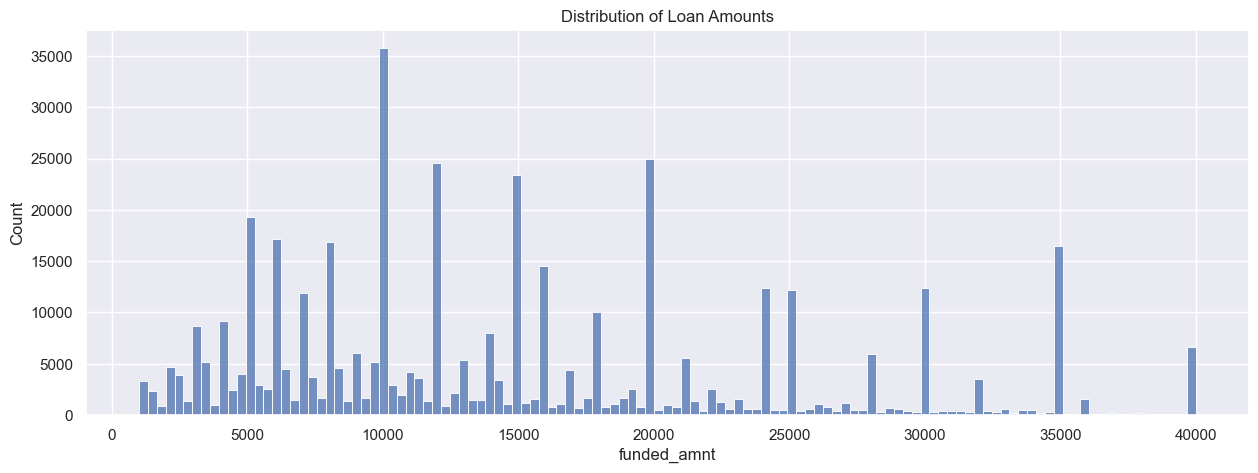

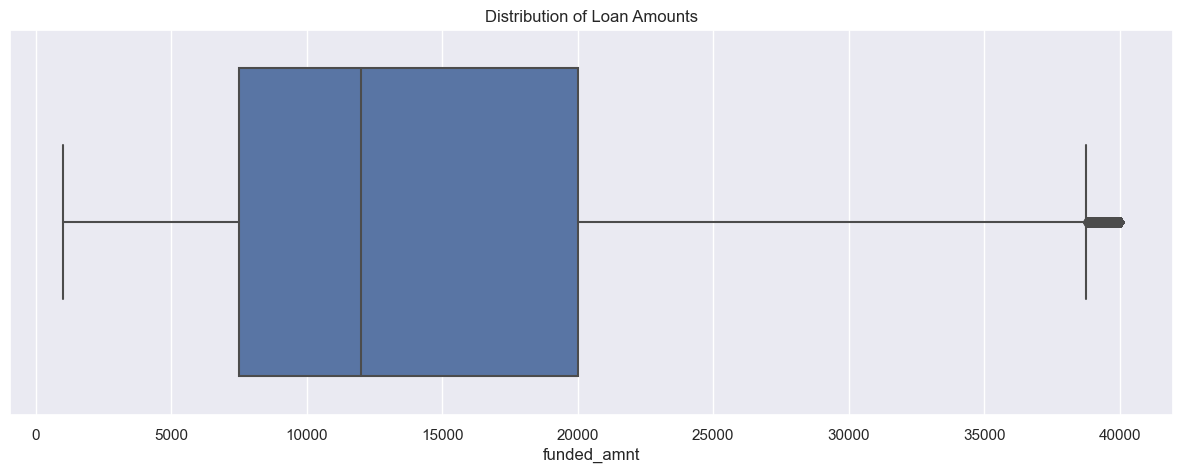

In [119]:
plt.figure(figsize=(15,5))
plt.title('Distribution of Loan Amounts')
sns.histplot(x='funded_amnt', data=loans)
plt.show()

plt.figure(figsize=(15,5))
plt.title('Distribution of Loan Amounts')
sns.boxplot(x='funded_amnt', data=loans)
plt.show()

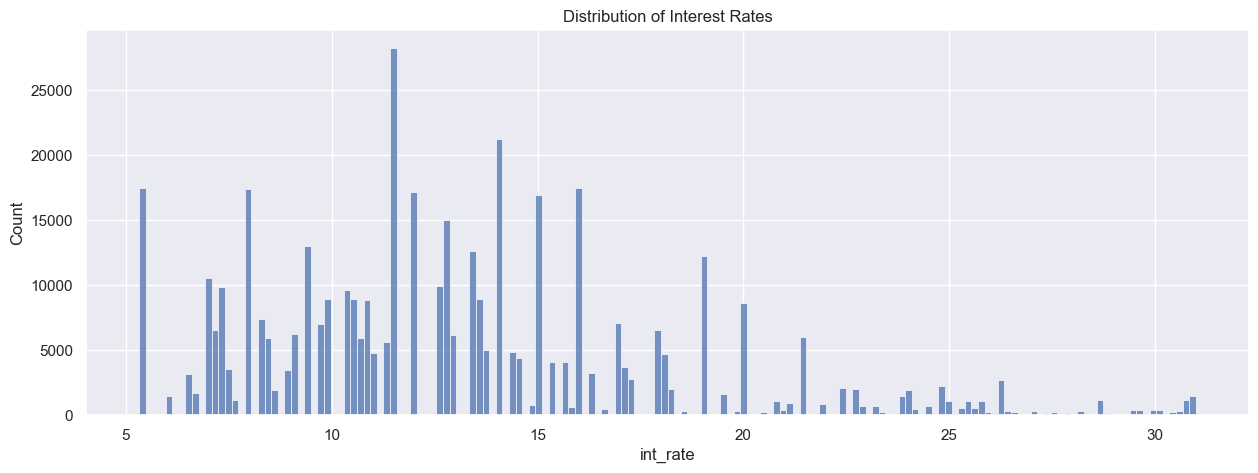

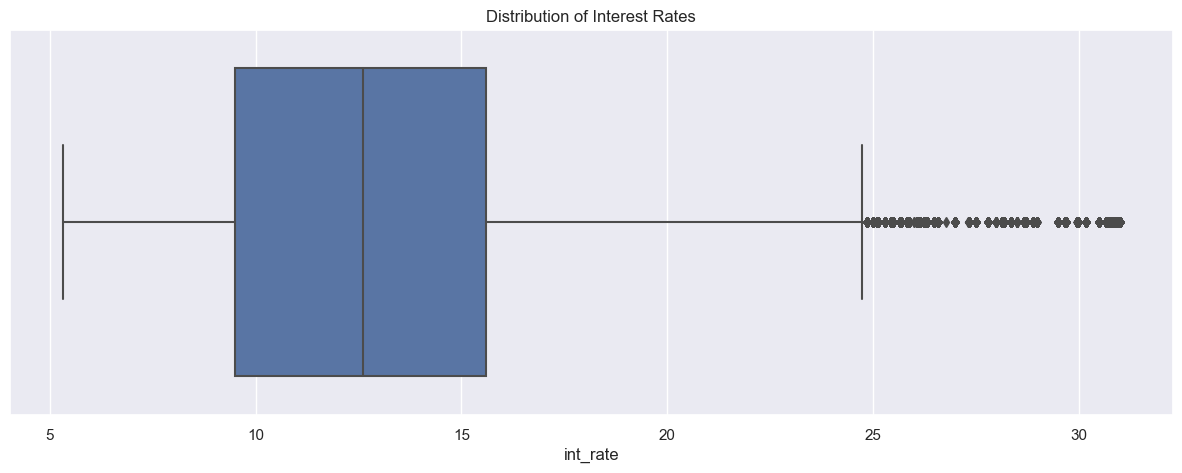

In [120]:
plt.figure(figsize=(15,5))
plt.title('Distribution of Interest Rates')
sns.histplot(x='int_rate', data=loans)
plt.show()

plt.figure(figsize=(15,5))
plt.title('Distribution of Interest Rates')
sns.boxplot(x='int_rate', data=loans)
plt.show()

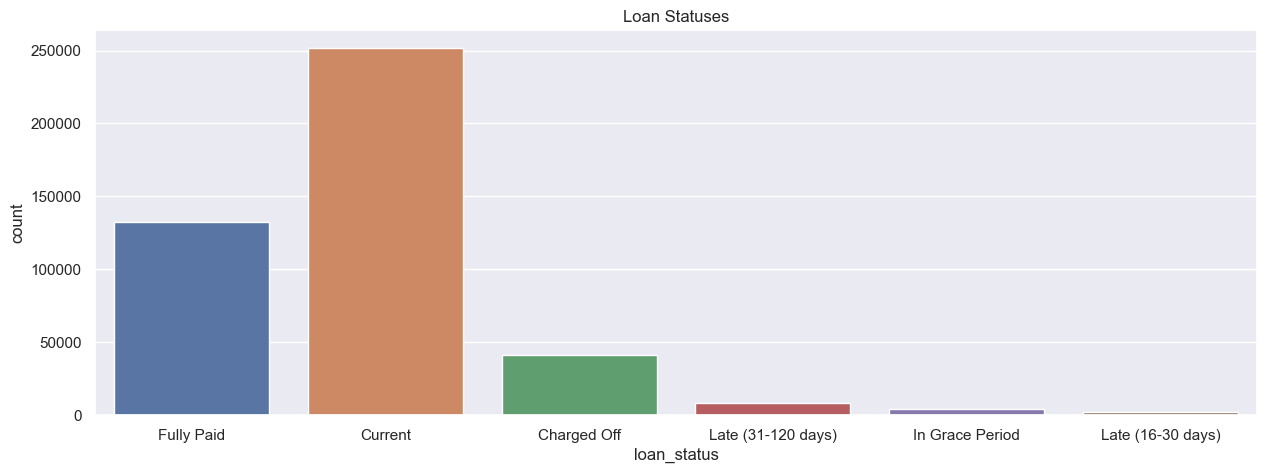

In [121]:
plt.figure(figsize=(15,5))
plt.title('Loan Statuses')
sns.countplot(data=loans,x="loan_status")
plt.show()

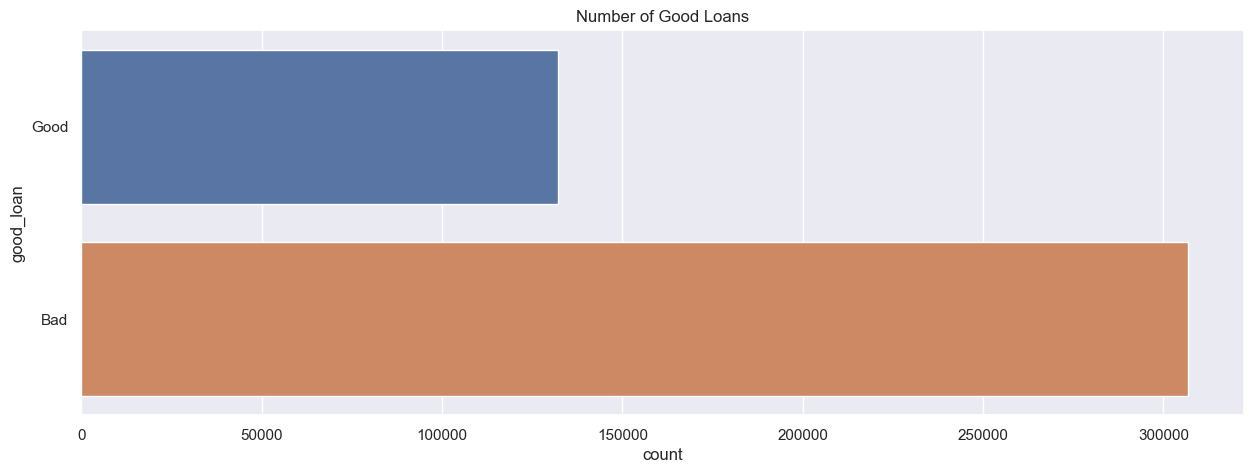

In [122]:
goodloans = loans['good_loan']
goodloans.replace(0.0, 'Bad', inplace=True)
goodloans.replace(1.0, 'Good', inplace=True)

plt.figure(figsize=(15,5))
plt.title('Number of Good Loans')
sns.countplot(y=goodloans)
plt.show()

### **1.3 Missing Values**

In [123]:
loans['good_loan'].replace('Bad', 0.0, inplace=True)
loans['good_loan'].replace('Good', 1.0, inplace=True)


def display_missing(df):
    nummissing = 0
    for col in df.columns.tolist():
        if df[col].isnull().sum() > 0:
            num_missing = df[col].isnull().sum()
            percent_missing = (num_missing / df.shape[0]) * 100
            print('{} column missing values: {} ({:.2f}%)'.format(col, num_missing, percent_missing))
            nummissing += 1
    if nummissing == 0:
        print('No missing values in the dataset')
    print('\n')

display_missing(loans)

emp_title column missing values: 30367 (6.92%)
emp_length column missing values: 30013 (6.84%)
dti column missing values: 285 (0.06%)
mths_since_last_delinq column missing values: 213676 (48.67%)
revol_util column missing values: 359 (0.08%)
annual_inc_joint column missing values: 413182 (94.12%)
dti_joint column missing values: 413183 (94.12%)
open_act_il column missing values: 27 (0.01%)
open_il_24m column missing values: 27 (0.01%)
il_util column missing values: 59565 (13.57%)
open_rv_24m column missing values: 27 (0.01%)
all_util column missing values: 74 (0.02%)
inq_last_12m column missing values: 27 (0.01%)
bc_open_to_buy column missing values: 5191 (1.18%)
bc_util column missing values: 5389 (1.23%)
mths_since_recent_bc column missing values: 4902 (1.12%)
mths_since_recent_bc_dlq column missing values: 331967 (75.62%)
mths_since_recent_revol_delinq column missing values: 285586 (65.06%)
percent_bc_gt_75 column missing values: 5217 (1.19%)
revol_bal_joint column missing values: 4

The features missing less than about 10% of their values (~10% NaN values) can have their missing rows dropped with a relatively negligable loss of data (<10% of dataset). The rest of the features with missing data can have their missing values imputed. The values will be imputed with -1 so the algorithm sees that these loans stand out from the loans without missing values.

In [134]:
low_missing = ['emp_title', 'emp_length', 'dti', 'revol_util', 'open_act_il', 'open_il_24m', 'open_rv_24m', 'all_util', 'inq_last_12m', 'bc_open_to_buy', 'bc_util', 'mths_since_recent_bc', 'percent_bc_gt_75']
negative_fill = ['il_util', 'mths_since_last_delinq', 'annual_inc_joint', 'dti_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths']

loans2 = loans.dropna(subset=low_missing, axis=0)

loans2[negative_fill] = loans2[negative_fill].fillna(value=-1)

display_missing(loans2)
print('New number of loans: ' + str(len(loans2)))
num_removed = len(loans) - len(loans2)
print('Number of loans removed from dataset: {} ({:.2f}%)'.format(num_removed, (num_removed/len(loans) * 100)))

No missing values in the dataset


New number of loans: 403555
Number of loans removed from dataset: 35436 (8.07%)


### **1.3 Categorical Features**

The following features contain strings that represent a category in the feature. These strings can be represented by dummy variables.

In [125]:
make_dummies = ['home_ownership', 'loan_status', 'purpose', 'application_type']
before = loans.shape[1]
loans = pd.get_dummies(loans, columns=make_dummies)
print('Number of new columns = ' + str(loans.shape[1] - before))

Number of new columns = 23


### **1.4 Correlations**

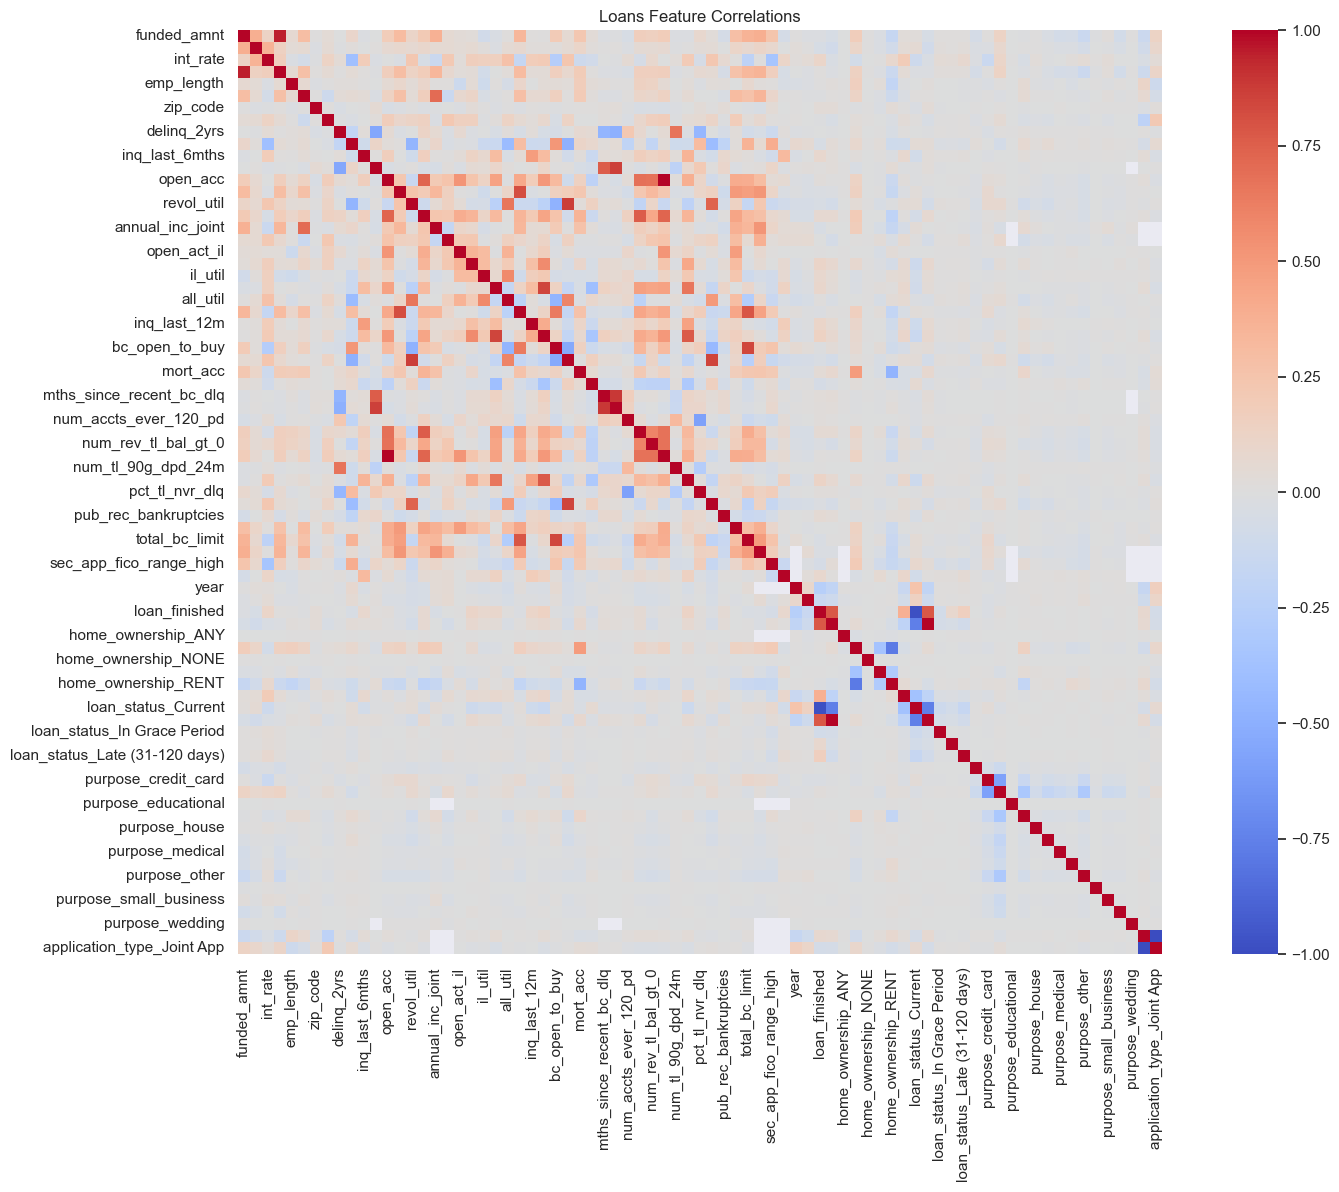

In [126]:
fig, axs = plt.subplots(nrows=1, figsize=(18, 12))
c = loans.corr()
sns.heatmap(loans.corr(),  annot=False, square=True, cmap='coolwarm')
plt.title('Loans Feature Correlations')
plt.show()

# **2. Loan Classification**

To determine if a loan is "good" or "bad" (invest or don't invest in) a classification algorithm can be used. A decision tree classifier was used here because of the high number of features. Other classification algorithms were used (logistic regression and random forest classifier), but the decision tree gave the best results.

In [127]:
y = loans2['good_loan']
drop_cols = ['good_loan', 'emp_title', 'addr_state', 'year', 'quarter', 'earliest_cr_line', 'sec_app_earliest_cr_line']
X = loans2.drop(columns=drop_cols)
X = X.drop(columns=make_dummies)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy: 0.8473074368860827
Precision: 0.7532991202346041
Recall: 0.7385565393537427



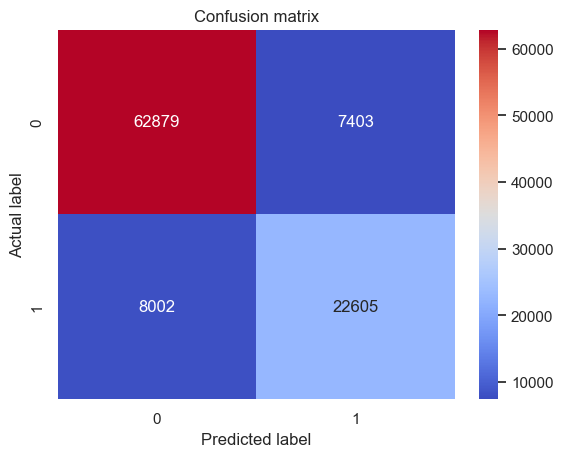

In [131]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision: {}".format(metrics.precision_score(y_test, y_pred)))
print("Recall: {}\n".format(metrics.recall_score(y_test, y_pred)))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
classes=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()